In [1]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN
import os
from model.utils import train, device
import torch

In [2]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import dense_to_sparse
from scipy.sparse import coo_matrix
import numpy as np
import os


class OpenCloseDataset(Dataset):

    def __init__(self, datafolder, test=False, transform=None, pre_transform=None, k_degree=10):

        self.test = test
        self.datafolder = datafolder
        self.open = np.load(f'{datafolder}/raw/open.npy')
        self.close = np.load(f'{datafolder}/raw/close.npy')
        self.k_degree = k_degree

        super().__init__(root=datafolder, transform=transform, pre_transform=pre_transform)

    @property
    def raw_file_names(self):
        return ['close.npy', 'open.npy']

    @property
    def processed_file_names(self):

        """ If these files are found in raw_dir, processing is skipped"""
        # todo test filenames
        if self.test:
            return [os.path.join(self.datafolder, 'processed', 'test', f'data_{i}.pt') for i in range(47+47)]

        else:
            return [os.path.join(self.datafolder, 'processed', f'data_{i}.pt') for i in range(47+47)]

    def download(self):
        # todo download data
        pass

    def process(self):

        for index, matr in enumerate(self.open):
            _ = self._load_and_save(matr, index, 'open')

        for index, matr in enumerate(self.close):
            _ = self._load_and_save(matr, index, 'close')

    def _load_and_save(self, matr, index, state):

        x = torch.from_numpy(matr).float()

        adj = self.compute_KNN_graph(matr, k_degree=self.k_degree)
        adj = torch.from_numpy(adj).float()

        edge_index, edge_attr = dense_to_sparse(adj)
        label = torch.tensor(0 if state == 'close' else 1).long()

        data = Data(x=x, edge_index=edge_index,
                    edge_attr=edge_attr, y=label)

        index = index + 47 if state == 'close' else index
        if self.test:
            torch.save(data,
                       os.path.join(self.processed_dir, 'test',
                                    f'data_{index}.pt'))
        else:
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))
        return data

    def compute_KNN_graph(self, matrix, k_degree):
        """ Calculate the adjacency matrix from the connectivity matrix."""

        matrix = np.abs(matrix)
        idx = np.argsort(-matrix)[:, 0:k_degree]
        matrix.sort()
        matrix = matrix[:, ::-1]
        matrix = matrix[:, 0:k_degree]

        A = self._adjacency(matrix, idx).astype(np.float32)

        return A

    def _adjacency(self, dist, idx):

        m, k = dist.shape
        assert m, k == idx.shape
        assert dist.min() >= 0

        # Weight matrix.
        I = np.arange(0, m).repeat(k)
        J = idx.reshape(m * k)
        V = dist.reshape(m * k)
        W = coo_matrix((V, (I, J)), shape=(m, m))

        # No self-connections.
        W.setdiag(0)

        # Non-directed graph.
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)

        return W.todense()

    def len(self):
        return 47+47  # len(self.files)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_{idx}.pt'))
        return data

In [20]:
full_dataset = OpenCloseDataset(datafolder='../data', k_degree=10).shuffle()
len(os.listdir('../data/processed'))

Processing...
Done!


96

In [21]:
train_size = int(0.9 * len(full_dataset))
train_dataset, val_dataset = full_dataset[:train_size], full_dataset[train_size:]

In [10]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv

class GCN(nn.Module):
    def __init__(self,
                 num_features,
                 num_classes,
                 channels,
                 dropout=0):
        super().__init__()

        self.p = dropout
        self.conv1 = GCNConv(int(num_features), channels[0])
        self.conv2 = GCNConv(channels[0], channels[1])
        self.conv3 = GCNConv(channels[1], channels[2])

        self.lin1 = nn.Linear(channels[2], int(num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        #print(x.shape)
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        #print(x.shape)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        x = F.relu(self.conv3(x, edge_index, edge_attr))
        #print(x.shape)
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.lin1(x)
        return x

In [39]:
from sklearn.metrics import precision_score, recall_score

def train_epoch(train_loader, model, criterion, optimizer):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def eval_epoch(loader, model, criterion):
    model.eval()
    losses = 0
    correct = 0
    pr = []
    rc = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)
        loss = criterion(out, data.y)
        losses += loss.item()
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        #print(pred)
        #print(data.y)
        pr.append(precision_score(data.y, pred, zero_division=0))
        rc.append(recall_score(data.y, pred, zero_division=0))
        # Derive ratio of correct predictions.
    return losses / len(loader.dataset), correct / len(loader.dataset), np.mean(pr), np.mean(rc)

def train(model, epochs, train_loader, val_loader, criterion, optimizer):
    losses = []
    for epoch in range(1, epochs):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(val_loader, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        losses.append((train_loss, val_loss))
    return losses

In [37]:
from torch.optim import lr_scheduler
model = GCN(full_dataset.num_features, 2, channels=[128, 32, 32], dropout=0.2).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 20
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


59138

In [28]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

In [40]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 001, Train Loss: 0.0905, Test Loss 0.3624, Train Acc: 0.5238, Test Acc: 0.3000
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 002, Train Loss: 0.0902, Test Loss 0.3710, Train Acc: 0.5238, Test Acc: 0.3000
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 003, Train Loss: 0.0903, Test Loss 0.3706, Train Acc: 0.5238, Test Acc: 0.3000


KeyboardInterrupt: 

In [133]:
train_loss, val_loss = zip(*history)

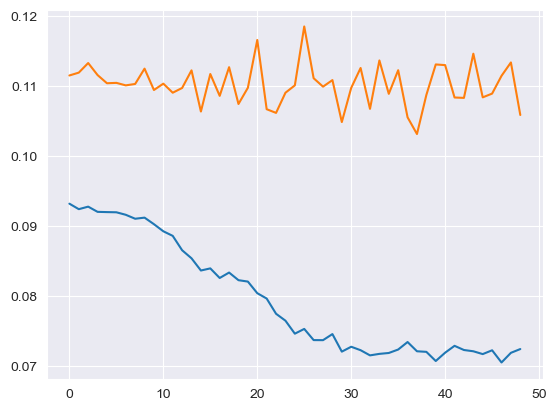

In [122]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
#plt.plot(acc)
#plt.plot(pres)

In [123]:
torch.save(model.state_dict(), '../weights/bs8_128_32_8_k10.pt')

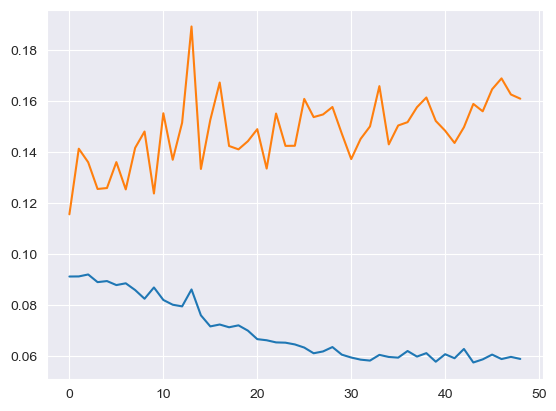

In [134]:
plt.plot(train_loss)
plt.plot(val_loss)

In [135]:
torch.save(model.state_dict(), '../weights/bs8_128_32_8_k5.pt')

In [42]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))

labels = [full_dataset[i].y for i in range(len(full_dataset))]

for n_fold, (train_idx, test_idx) in enumerate(skf.split(labels, labels)):
    model = GCN(full_dataset.num_features, 2, channels=[256, 32, 32], dropout=0.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    train_loader_ = DataLoader(full_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(full_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    print()
    for epoch in range(20):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, train_pr, train_rc = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, val_pr, val_rc = eval_epoch(val_loader, model, criterion)
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc
            best_pr = val_pr
            best_rc = val_rc

    eval_metrics[n_fold, 0] = val_pr
    eval_metrics[n_fold, 1] = val_rc
    eval_metrics[n_fold, 2] = best_test_acc

0

Epoch: 000, Train Loss: 0.0904, Test Loss 0.3662, Train Acc: 0.5238, Test Acc: 0.3000
Train Prec: 0.000, Train Rec: 0.000, Test Prec: 0.000, Test Rec: 0.000
Epoch: 001, Train Loss: 0.0905, Test Loss 0.3722, Train Acc: 0.5238, Test Acc: 0.3000
Train Prec: 0.000, Train Rec: 0.000, Test Prec: 0.000, Test Rec: 0.000
Epoch: 002, Train Loss: 0.0905, Test Loss 0.3619, Train Acc: 0.5238, Test Acc: 0.3000
Train Prec: 0.000, Train Rec: 0.000, Test Prec: 0.000, Test Rec: 0.000
Epoch: 003, Train Loss: 0.0901, Test Loss 0.3646, Train Acc: 0.5238, Test Acc: 0.3000
Train Prec: 0.000, Train Rec: 0.000, Test Prec: 0.000, Test Rec: 0.000
Epoch: 004, Train Loss: 0.0901, Test Loss 0.3652, Train Acc: 0.5238, Test Acc: 0.3000
Train Prec: 0.000, Train Rec: 0.000, Test Prec: 0.000, Test Rec: 0.000
Epoch: 005, Train Loss: 0.0897, Test Loss 0.3576, Train Acc: 0.5595, Test Acc: 0.3000
Train Prec: 0.152, Train Rec: 0.091, Test Prec: 0.000, Test Rec: 0.000
Epoch: 006, Train Loss: 0.0894, Test Loss 0.3667, Train

In [43]:
eval_metrics

array([[0.2, 0.1, 0.8],
       [0.6, 0.6, 0.7],
       [0. , 0. , 0.6],
       [0.8, 0.7, 0.8],
       [0.7, 0.8, 0.7],
       [0.9, 0.9, 0.7],
       [0.8, 0.6, 0.7],
       [0.7, 0.8, 0.9],
       [0.3, 0.4, 0.8],
       [0.6, 0.5, 0.8]])